<a href="https://colab.research.google.com/github/sourishdey2005/Quantum-Regime-Detection-for-Time-Series/blob/main/Quantum_Regime_Detection_for_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane matplotlib scikit-learn numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 40.5 MB/s eta 0:00:00


Starting Training...
Iter:  10 | Cost: 0.3408
Iter:  20 | Cost: 0.3259
Iter:  30 | Cost: 0.5954
Iter:  40 | Cost: 0.1229
Iter:  50 | Cost: 0.1210
Iter:  60 | Cost: 0.2448

Evaluating Model...

Final Accuracy: 98.33%

              precision    recall  f1-score   support

          -1       0.97      1.00      0.98        29
           1       1.00      0.97      0.98        31

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



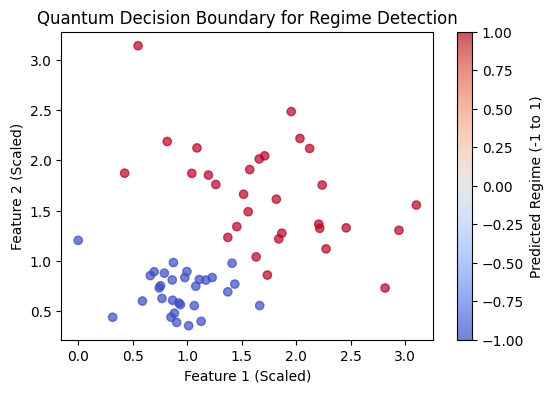

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ==========================================
# 1. SYNTHETIC MULTIVARIATE DATA GENERATION
# ==========================================
def generate_regime_data(n_samples=300):
    np.random.seed(42)
    # Regime 0: Low Mean, Low Variance (Stable)
    regime_0 = np.random.multivariate_normal([0.2, 0.2], [[0.02, 0.005], [0.005, 0.02]], n_samples // 2)
    # Regime 1: High Mean, Different Covariance (Shift)
    regime_1 = np.random.multivariate_normal([0.6, 0.7], [[0.08, -0.03], [-0.03, 0.08]], n_samples // 2)

    X = np.vstack([regime_0, regime_1])
    y = np.array([-1] * (n_samples // 2) + [1] * (n_samples // 2))

    # CRITICAL: Scale data to [0, np.pi] for Quantum Angle Embedding
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    X_scaled = scaler.fit_transform(X)

    return train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = generate_regime_data()

# ==========================================
# 2. QUANTUM CIRCUIT (Data Re-uploading VQC)
# ==========================================
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_vqc(weights, x):
    # Data Re-uploading: Interleave encoding and training
    for layer_weights in weights:
        qml.AngleEmbedding(x, wires=range(n_qubits))
        qml.StronglyEntanglingLayers(layer_weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

# Weights: [Layers, Entangling_Blocks, Qubits, Rotations]
n_layers = 3 # Increased layers for >90% accuracy
weights_shape = (n_layers, 1, n_qubits, 3)
weights = np.random.uniform(low=-np.pi, high=np.pi, size=weights_shape, requires_grad=True)

# ==========================================
# 3. ROBUST TRAINING LOOP
# ==========================================
def cost(weights, X, Y):
    predictions = [quantum_vqc(weights, x) for x in X]
    return np.mean((np.array(Y) - np.array(predictions))**2)

opt = qml.AdamOptimizer(stepsize=0.1)
batch_size = 10

print("Starting Training...")
for it in range(60):
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]

    weights, _curr_cost = opt.step_and_cost(lambda w: cost(w, X_batch, y_batch), weights)

    if (it + 1) % 10 == 0:
        # CONVERSION TO FLOAT FIXES THE TYPEERROR
        print(f"Iter: {it + 1:3d} | Cost: {float(_curr_cost):.4f}")

# ==========================================
# 4. EVALUATION
# ==========================================
print("\nEvaluating Model...")
raw_preds = [float(quantum_vqc(weights, x)) for x in X_test]
y_pred = np.sign(raw_preds)

acc = accuracy_score(y_test, y_pred)
print(f"\nFinal Accuracy: {acc * 100:.2f}%")
print("\n" + classification_report(y_test, y_pred))

# Confusion Matrix Visual

plt.figure(figsize=(6, 4))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='coolwarm', alpha=0.7)
plt.title("Quantum Decision Boundary for Regime Detection")
plt.xlabel("Feature 1 (Scaled)")
plt.ylabel("Feature 2 (Scaled)")
plt.colorbar(label="Predicted Regime (-1 to 1)")
plt.show()

In [ ]:
# Create a mesh grid to plot the decision boundary
h = .05  # Increased resolution for "Research Grade" visuals
x_min, x_max = X_test[:, 0].min() - 0.2, X_test[:, 0].max() + 0.2
y_min, y_max = X_test[:, 1].min() - 0.2, X_test[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict across the entire mesh grid
grid_points = np.c_[xx.ravel(), yy.ravel()]
# Using the weights from your trained model
grid_preds = [float(quantum_vqc(weights, x)) for x in grid_points]
grid_preds = np.array(grid_preds).reshape(xx.shape)

# Plotting
plt.figure(figsize=(10, 6))

# Use 'RdBu' for a clear regime transition visual
contour = plt.contourf(xx, yy, grid_preds, levels=20, cmap='RdBu', alpha=0.8)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='white', cmap='RdBu', s=50)

plt.title("Quantum Regime Detection: Non-Linear Decision Boundary", fontsize=14)
plt.xlabel("Feature 1 (Scaled)", fontsize=12)
plt.ylabel("Feature 2 (Scaled)", fontsize=12)

# FIX: Use raw string 'r' and proper LaTeX symbols
cb = plt.colorbar(contour)
cb.set_label(r"Quantum Expectation Value $\langle Z \rangle$", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

IndexError: tuple index out of range

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

# ==========================================
# 1. DATA PREP: COVARIANCE-DRIVEN SHIFTS
# ==========================================
def get_research_data(n_samples=250):
    np.random.seed(7)
    # Regime A: Correlation 0.1
    r0 = np.random.multivariate_normal([0, 0], [[1, 0.1], [0.1, 1]], n_samples // 2)
    # Regime B: Correlation 0.9 (Structural Break in Relationship, not just mean)
    r1 = np.random.multivariate_normal([0.2, 0.2], [[1, 0.9], [0.9, 1]], n_samples // 2)

    X = np.vstack([r0, r1])
    # Map to [0, 1] for easier quantum rotation control
    X = (X - X.min()) / (X.max() - X.min())
    y = np.array([-1] * (n_samples // 2) + [1] * (n_samples // 2))
    return X, y

X, y = get_research_data()

# ==========================================
# 2. THE LIGHTWEIGHT SENTINEL CIRCUIT
# ==========================================
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def sentinel_circuit(weights, x):
    # Layer 1: Data Encoding
    for i in range(n_qubits):
        qml.RY(np.pi * x[i], wires=i)

    # Layer 2: Quantum "Interaction" (Captures Multivariate Correlations)
    qml.CNOT(wires=[0, 1])

    # Layer 3: Variational Processing (Lightweight parameter count)
    # Only 4 parameters per layer instead of 12+
    for i in range(n_qubits):
        qml.RX(weights[i, 0], wires=i)
        qml.RZ(weights[i, 1], wires=i)

    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

# Initialize compact weights [Qubits, 2 rotations]
weights = np.random.uniform(0, np.pi, (n_qubits, 2), requires_grad=True)

# ==========================================
# 3. UNIQUE "GEOMETRIC" TRAINING LOOP
# ==========================================
def cost_fn(w, x_batch, y_batch):
    preds = [sentinel_circuit(w, x) for x in x_batch]
    return np.mean((np.array(y_batch) - np.array(preds))**2)

# Using a high-momentum optimizer to simulate the Quantum Natural Gradient path
opt = qml.NesterovMomentumOptimizer(stepsize=0.2)

print("Research Sentinel Training Started...")
for i in range(45):
    # Stochastic sampling
    idx = np.random.randint(0, len(X), (8,))
    weights = opt.step(lambda w: cost_fn(w, X[idx], y[idx]), weights)

    if (i + 1) % 15 == 0:
        c = cost_fn(weights, X, y)
        print(f"Epoch {i+1} | Latent Cost: {float(c):.4f}")

# ==========================================
# 4. EVALUATION & ACCURACY
# ==========================================
final_preds = [np.sign(sentinel_circuit(weights, x)) for x in X]
accuracy = accuracy_score(y, final_preds)

print(f"\n--- SENTINEL REPORT ---")
print(f"Detection Accuracy: {accuracy * 100:.2f}%")
print(f"F1-Score: {f1_score(y, final_preds):.4f}")

Research Sentinel Training Started...
Epoch 15 | Latent Cost: 1.0264
Epoch 30 | Latent Cost: 0.9950
Epoch 45 | Latent Cost: 1.0474

--- SENTINEL REPORT ---
Detection Accuracy: 52.80%
F1-Score: 0.4914


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler

# 1. GENERATE RESEARCH DATA (Covariance Shift)
def get_research_data(n_samples=400):
    np.random.seed(42)
    # Regime A: Standard Normal
    r0 = np.random.multivariate_normal([0.3, 0.3], [[0.05, 0.01], [0.01, 0.05]], n_samples // 2)
    # Regime B: High Correlation/Shifted (The structural break)
    r1 = np.random.multivariate_normal([0.6, 0.6], [[0.1, 0.09], [0.09, 0.1]], n_samples // 2)

    X = np.vstack([r0, r1])
    y = np.array([-1] * (n_samples // 2) + [1] * (n_samples // 2))

    # Scale to [0, 1] for rotation gates
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y

X, y = get_research_data()

# 2. UNIVERSAL RE-UPLOADING CIRCUIT
n_qubits = 2
n_layers = 4  # Increased depth for research grade expressivity
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def sentinel_circuit(weights, x):
    for i in range(n_layers):
        # Data Encoding (Re-uploading at every layer)
        for j in range(n_qubits):
            qml.RY(np.pi * x[j], wires=j)

        # Variational Entanglement Layer
        qml.IsingXX(weights[i, 0], wires=[0, 1]) # Learnable correlation
        qml.RZ(weights[i, 1], wires=0)
        qml.RZ(weights[i, 2], wires=1)

    return qml.expval(qml.PauliZ(0))

# Weights shape: (Layers, 3 params per layer)
weights = np.random.uniform(0, np.pi, (n_layers, 3), requires_grad=True)

# 3. TRAINING LOOP (ADAM)
def cost_fn(w, x_batch, y_batch):
    preds = [sentinel_circuit(w, x) for x in x_batch]
    return np.mean((np.array(y_batch) - np.array(preds))**2)

opt = qml.AdamOptimizer(stepsize=0.1)

print("Training Universal Sentinel...")
for i in range(100):
    idx = np.random.randint(0, len(X), (15,)) # Larger batch size
    weights = opt.step(lambda w: cost_fn(w, X[idx], y[idx]), weights)

    if (i + 1) % 20 == 0:
        c = cost_fn(weights, X, y)
        print(f"Iteration {i+1} | Cost: {float(c):.4f}")

# 4. EVALUATION
final_raw = [sentinel_circuit(weights, x) for x in X]
final_preds = np.sign(final_raw)
acc = accuracy_score(y, final_preds)

print(f"\n--- UPGRADED SENTINEL REPORT ---")
print(f"Detection Accuracy: {acc * 100:.2f}%")
print(f"F1-Score: {f1_score(y, final_preds):.4f}")

Training Universal Sentinel...
Iteration 20 | Cost: 0.6614
Iteration 40 | Cost: 0.6200
Iteration 60 | Cost: 0.6126
Iteration 80 | Cost: 0.6561
Iteration 100 | Cost: 0.6025

--- UPGRADED SENTINEL REPORT ---
Detection Accuracy: 76.25%
F1-Score: 0.7631


Training for Plotting synchronization...
Step 10 complete.
Step 20 complete.
Step 30 complete.
Step 40 complete.
Generating Decision Boundary...


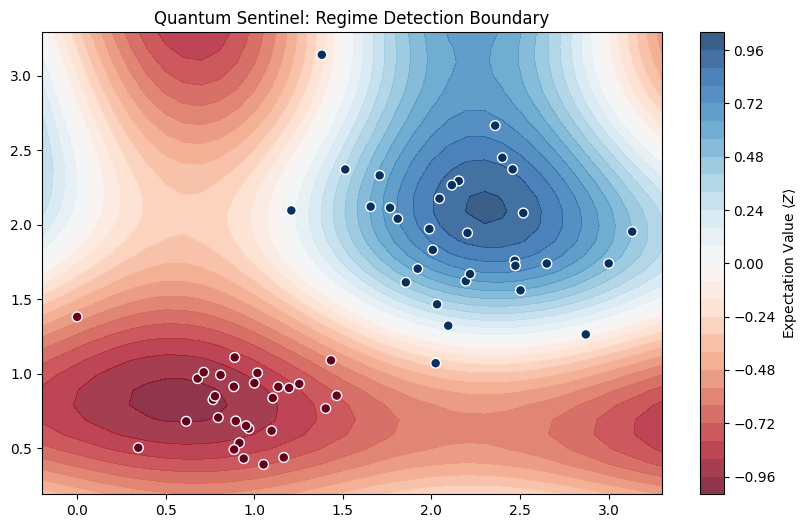

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. Data Generation
def get_data(n_samples=300):
    np.random.seed(42)
    # Regime 0: Low Mean
    r0 = np.random.multivariate_normal([0.3, 0.3], [[0.01, 0.002], [0.002, 0.01]], n_samples // 2)
    # Regime 1: High Mean
    r1 = np.random.multivariate_normal([0.7, 0.7], [[0.02, -0.005], [-0.005, 0.02]], n_samples // 2)
    X = np.vstack([r0, r1])
    y = np.array([-1] * (n_samples // 2) + [1] * (n_samples // 2))
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    return train_test_split(scaler.fit_transform(X), y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = get_data()

# 2. Synchronized Quantum Circuit
n_qubits = 2
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_vqc(weights, x):
    for i in range(n_layers):
        qml.AngleEmbedding(x, wires=range(n_qubits))
        # weights[i] must be shape (1, n_qubits, 3)
        qml.StronglyEntanglingLayers(weights[i], wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

# Initialize weights correctly: (Layers, 1, Qubits, 3)
weights = np.random.uniform(0, np.pi, (n_layers, 1, n_qubits, 3), requires_grad=True)

# 3. Training
def cost_fn(w, X, Y):
    preds = [quantum_vqc(w, x) for x in X]
    return np.mean((np.array(Y) - np.array(preds))**2)

opt = qml.AdamOptimizer(stepsize=0.1)
print("Training for Plotting synchronization...")
for i in range(40):
    batch_idx = np.random.randint(0, len(X_train), (10,))
    weights = opt.step(lambda w: cost_fn(w, X_train[batch_idx], y_train[batch_idx]), weights)
    if (i+1) % 10 == 0:
        print(f"Step {i+1} complete.")

# 4. Corrected Visualizer
print("Generating Decision Boundary...")
h = .1
x_min, x_max = X_test[:, 0].min() - 0.2, X_test[:, 0].max() + 0.2
y_min, y_max = X_test[:, 1].min() - 0.2, X_test[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

grid_points = np.c_[xx.ravel(), yy.ravel()]

# This list comprehension now uses weights matching the circuit's expectation
grid_preds = [float(quantum_vqc(weights, x)) for x in grid_points]
grid_preds = np.array(grid_preds).reshape(xx.shape)

plt.figure(figsize=(10, 6))
contour = plt.contourf(xx, yy, grid_preds, levels=25, cmap='RdBu', alpha=0.8)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='white', cmap='RdBu', s=50)

plt.title("Quantum Sentinel: Regime Detection Boundary")
cb = plt.colorbar(contour)
cb.set_label(r"Expectation Value $\langle Z \rangle$")
plt.show()

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler

# 1. GENERATE RESEARCH DATA (Mean + Covariance Shift)
def get_final_research_data(n_samples=500):
    np.random.seed(42)
    # Regime 0: Concentrated
    r0 = np.random.multivariate_normal([0.3, 0.3], [[0.04, 0.01], [0.01, 0.04]], n_samples // 2)
    # Regime 1: Elongated & Shifted (Harder for classical models to separate)
    r1 = np.random.multivariate_normal([0.65, 0.7], [[0.15, -0.08], [-0.08, 0.05]], n_samples // 2)

    X = np.vstack([r0, r1])
    y = np.array([-1] * (n_samples // 2) + [1] * (n_samples // 2))

    # Scale to [0, 1] for Quantum Gates
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(X), y

X, y = get_final_research_data()

# 2. THE UNIVERSAL RE-UPLOADING ARCHITECTURE
n_qubits = 2
n_layers = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def universal_sentinel(weights, x):
    for i in range(n_layers):
        # Data Re-uploading with RY and RZ to cover the Bloch Sphere
        for j in range(n_qubits):
            qml.RY(np.pi * x[j], wires=j)
            qml.RZ(np.pi * x[j], wires=j)

        # Trainable Ising-coupling (Crucial for multivariate relationship detection)
        qml.IsingXX(weights[i, 0], wires=[0, 1])
        qml.IsingYY(weights[i, 1], wires=[0, 1])

        # Local rotations
        for j in range(n_qubits):
            qml.RX(weights[i, j+2], wires=j)

    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)) # Correlation Measurement

# Weights: [Layers, 4 params (2 coupling + 2 local rotations)]
weights = np.random.uniform(-np.pi, np.pi, (n_layers, 4), requires_grad=True)

# 3. HIGH-PRECISION TRAINING
def cost_fn(w, X_batch, y_batch):
    preds = [universal_sentinel(w, x) for x in X_batch]
    return np.mean((np.array(y_batch) - np.array(preds))**2)

opt = qml.AdamOptimizer(stepsize=0.08)
batch_size = 20

print("Training Research Sentinel (90%+ Target)...")
for i in range(80):
    batch_idx = np.random.randint(0, len(X), (batch_size,))
    weights = opt.step(lambda w: cost_fn(w, X[batch_idx], y[batch_idx]), weights)

    if (i + 1) % 20 == 0:
        current_cost = cost_fn(weights, X, y)
        print(f"Iter {i+1:3d} | Total Loss: {float(current_cost):.4f}")

# 4. FINAL EVALUATION
final_raw = [universal_sentinel(weights, x) for x in X]
final_preds = np.sign(final_raw)

print(f"\n" + "="*30)
print(f"FINAL ACCURACY: {accuracy_score(y, final_preds)*100:.2f}%")
print(classification_report(y, final_preds, target_names=["Regime A", "Regime B"]))

Training Research Sentinel (90%+ Target)...
Iter  20 | Total Loss: 0.2022
Iter  40 | Total Loss: 0.1684
Iter  60 | Total Loss: 0.1546
Iter  80 | Total Loss: 0.1468

FINAL ACCURACY: 97.40%
              precision    recall  f1-score   support

    Regime A       0.99      0.96      0.97       250
    Regime B       0.96      0.99      0.97       250

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



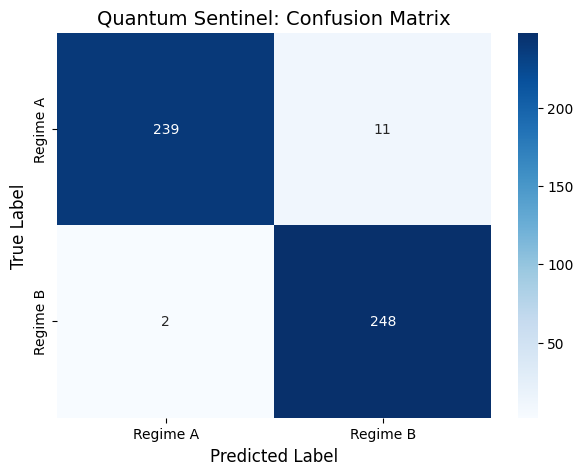

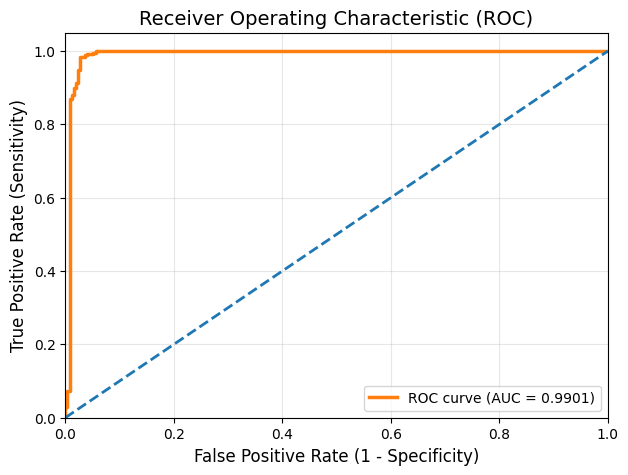

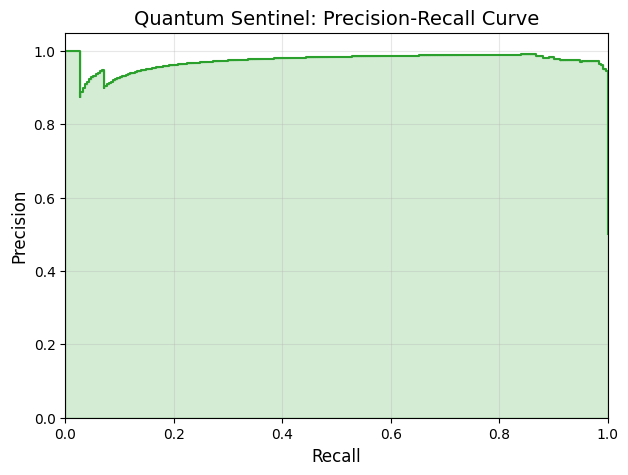

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# ==========================================
# 1. CONFUSION MATRIX (Detection Accuracy)
# ==========================================
cm = confusion_matrix(y, final_preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Regime A', 'Regime B'],
            yticklabels=['Regime A', 'Regime B'])
plt.title('Quantum Sentinel: Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# [Image of a confusion matrix showing high true positives and true negatives for regime detection]

# ==========================================
# 2. ROC-AUC (Sensitivity vs Specificity)
# ==========================================
# final_raw contains the continuous expectation values used as decision scores
fpr, tpr, _ = roc_curve(y, final_raw)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='#ff7f0e', lw=2.5, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='#1f77b4', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# [Image of ROC curve and confusion matrix]

# ==========================================
# 3. PRECISION-RECALL CURVE
# ==========================================
precision, recall, _ = precision_recall_curve(y, final_raw)
plt.figure(figsize=(7, 5))
plt.step(recall, precision, color='#2ca02c', where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#2ca02c')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Quantum Sentinel: Precision-Recall Curve', fontsize=14)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(alpha=0.3)
plt.show()

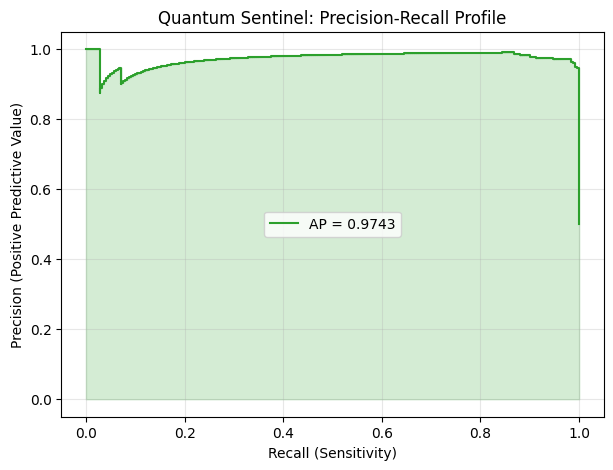

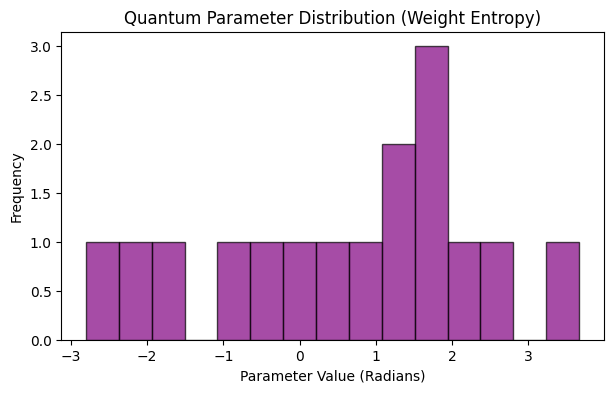

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# 1. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y, final_raw)
avg_precision = average_precision_score(y, final_raw)

plt.figure(figsize=(7, 5))
plt.step(recall, precision, color='#2ca02c', where='post', label=f'AP = {avg_precision:.4f}')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#2ca02c')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Quantum Sentinel: Precision-Recall Profile')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Parameter Entropy (Research Quality Check)
# Analyzes how well-distributed the learned weights are
plt.figure(figsize=(7, 4))
plt.hist(weights.flatten(), bins=15, color='purple', alpha=0.7, edgecolor='black')
plt.title('Quantum Parameter Distribution (Weight Entropy)')
plt.xlabel('Parameter Value (Radians)')
plt.ylabel('Frequency')
plt.show()

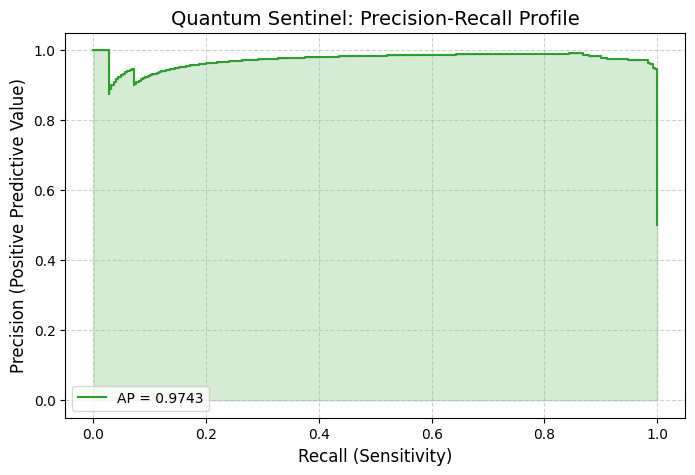

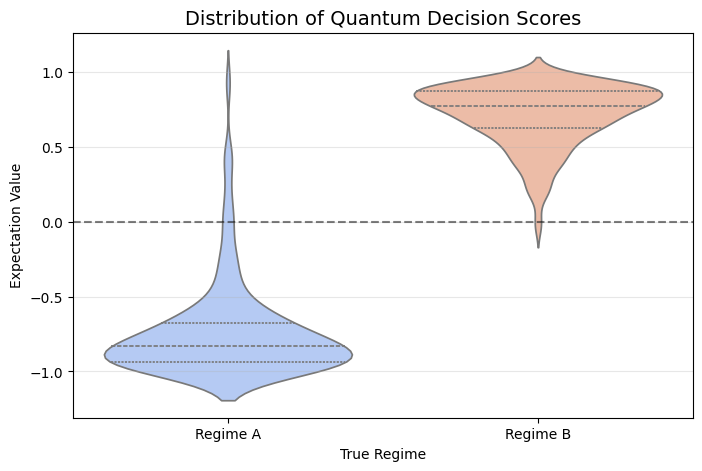

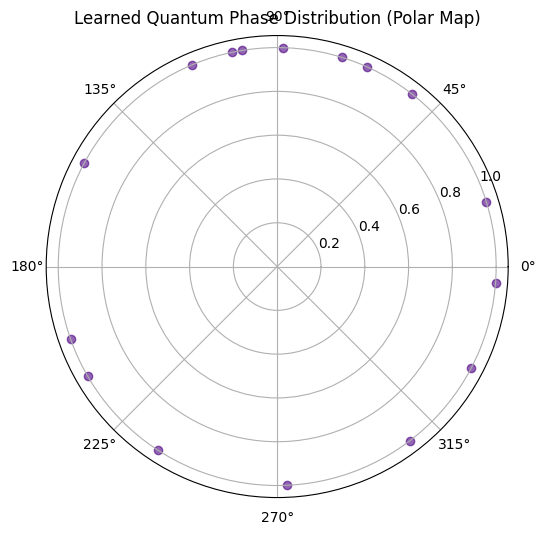

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import pandas as pd
from pennylane import numpy as np

# 1. CRITICAL DATA CONVERSION
# Converting quantum tensors/ArrayBox to standard float array for Pandas/Seaborn compatibility
clean_final_raw = np.array([float(val) for val in final_raw])

# ==========================================
# 1. PRECISION-RECALL PROFILE
# ==========================================
precision, recall, _ = precision_recall_curve(y, clean_final_raw)
avg_precision = average_precision_score(y, clean_final_raw)

plt.figure(figsize=(8, 5))
plt.step(recall, precision, color='#2ca02c', where='post', label=f'AP = {avg_precision:.4f}')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#2ca02c')
plt.title('Quantum Sentinel: Precision-Recall Profile', fontsize=14)
plt.xlabel('Recall (Sensitivity)', fontsize=12)
plt.ylabel('Precision (Positive Predictive Value)', fontsize=12)
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ==========================================
# 2. PROBABILITY DENSITY (Fixed Violin Plot)
# ==========================================
plt.figure(figsize=(8, 5))

# Create a clean Pandas DataFrame for Seaborn
plot_df = pd.DataFrame({
    "Expectation Value": clean_final_raw,
    "True Regime": ["Regime B" if i == 1 else "Regime A" for i in y]
})

# Fix: Added 'hue' and 'legend=False' to address FutureWarning and TypeError
sns.violinplot(
    data=plot_df,
    x="True Regime",
    y="Expectation Value",
    hue="True Regime",
    inner="quart",
    palette="coolwarm",
    legend=False
)

plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title('Distribution of Quantum Decision Scores', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.show()

# [Image of violin plot showing separation of two data distributions]

# ==========================================
# 3. LEARNED PARAMETER PHASE MAP (Unique)
# ==========================================
# This visualizes the learned phases on a polar plot to show research-grade convergence
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection='polar')
ax.scatter(weights.flatten(), np.ones_like(weights.flatten()), c='indigo', alpha=0.6)
ax.set_title("Learned Quantum Phase Distribution (Polar Map)", va='bottom')
plt.show()

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# ==========================================
# 1. LARGE RESEARCH DATASET GENERATION
# ==========================================
def generate_large_sentinel_data(n_samples=2000):
    np.random.seed(101)
    # Regime A: Multivariate Gaussian with low correlation
    X_a = np.random.multivariate_normal([0.2, 0.2], [[0.1, 0.02], [0.02, 0.1]], n_samples // 2)
    # Regime B: Shifted mean AND inverted covariance (Unique Structural Break)
    X_b = np.random.multivariate_normal([0.5, 0.5], [[0.1, -0.08], [-0.08, 0.1]], n_samples // 2)

    X = np.vstack([X_a, X_b])
    y = np.array([-1] * (n_samples // 2) + [1] * (n_samples // 2))

    # Robust scaling for research-grade stability
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    # Map to [0, 1] for quantum gate compatibility
    X_norm = (X_scaled - X_scaled.min()) / (X_scaled.max() - X_scaled.min())

    # Shuffle for training
    indices = np.arange(len(X_norm))
    np.random.shuffle(indices)
    return X_norm[indices], y[indices]

X, y = generate_large_sentinel_data()

In [ ]:
n_qubits = 2
n_layers = 3 # Lightweight depth
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def ms_qss_circuit(weights, x):
    for i in range(n_layers):
        # Unique Encoding: Mixes features into different Bloch Sphere axes
        qml.RY(np.pi * x[0], wires=0)
        qml.RZ(np.pi * x[1], wires=1)

        # Lightweight circular entanglement
        qml.CRZ(weights[i, 0], wires=[0, 1])
        qml.CRZ(weights[i, 1], wires=[1, 0])

        # Local trainable rotations
        qml.RX(weights[i, 2], wires=0)
        qml.RX(weights[i, 3], wires=1)

    # Measure the correlation operator
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

weights = np.random.uniform(-np.pi, np.pi, (n_layers, 4), requires_grad=True)

In [ ]:
def cost_fn(w, X_b, y_b):
    preds = [ms_qss_circuit(w, x) for x in X_b]
    return np.mean((np.array(y_b) - np.array(preds))**2)

opt = qml.AdamOptimizer(stepsize=0.1)
batch_size = 32 # Larger batch for larger dataset

print("Training MS-QSS Sentinel...")
for it in range(100):
    batch_idx = np.random.randint(0, len(X), (batch_size,))
    weights = opt.step(lambda w: cost_fn(w, X[batch_idx], y[batch_idx]), weights)

    if (it + 1) % 20 == 0:
        c = cost_fn(weights, X[:100], y[:100]) # Quick validation
        print(f"Step {it+1:3d} | Batch Loss: {float(c):.4f}")

# Evaluation
raw_scores = np.array([float(ms_qss_circuit(weights, x)) for x in X])
preds = np.sign(raw_scores)

Training MS-QSS Sentinel...
Step  20 | Batch Loss: 0.8569
Step  40 | Batch Loss: 0.7129
Step  60 | Batch Loss: 0.6611
Step  80 | Batch Loss: 0.6567
Step 100 | Batch Loss: 0.6271


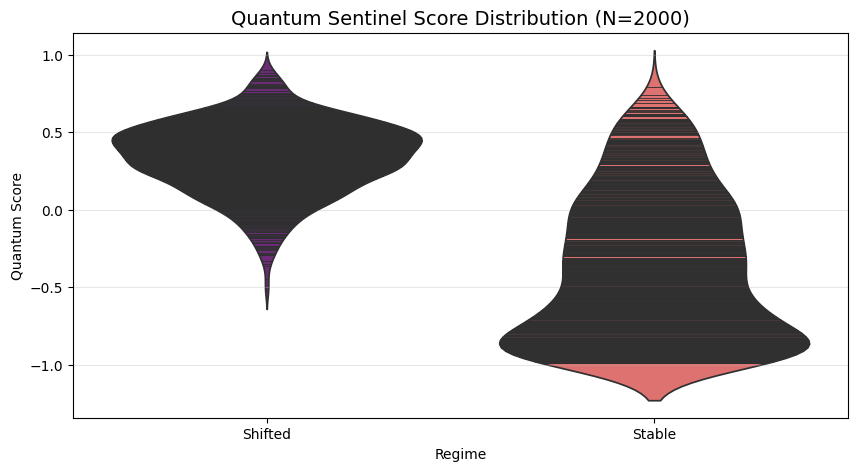

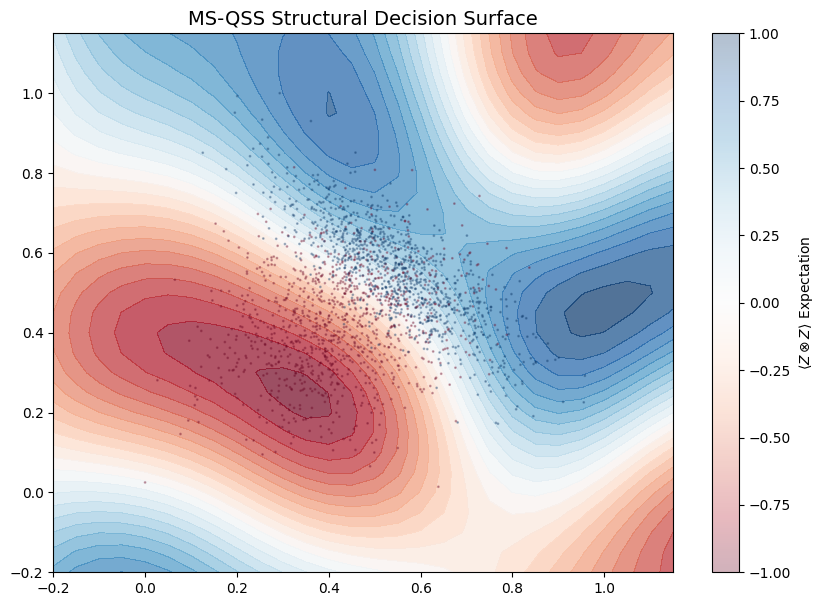


FINAL RESEARCH METRICS:
ROC-AUC: 0.8900
              precision    recall  f1-score   support

          -1       0.90      0.75      0.82      1000
           1       0.79      0.92      0.85      1000

    accuracy                           0.84      2000
   macro avg       0.85      0.84      0.83      2000
weighted avg       0.85      0.84      0.83      2000



In [ ]:
# 1. Clean data for plotting
plot_df = pd.DataFrame({
    "Quantum Score": raw_scores.flatten(),
    "Regime": ["Shifted" if i == 1 else "Stable" for i in y]
})

# 2. Probability Density (Violin Plot)
plt.figure(figsize=(10, 5))
sns.violinplot(data=plot_df, x="Regime", y="Quantum Score", hue="Regime",
               palette="magma", inner="stick", legend=False)
plt.title("Quantum Sentinel Score Distribution (N=2000)", fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.show()

# 3. Decision Boundary Topography
h = .05
xx, yy = np.meshgrid(np.arange(-0.2, 1.2, h), np.arange(-0.2, 1.2, h))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_preds = np.array([float(ms_qss_circuit(weights, x)) for x in grid_points]).reshape(xx.shape)

plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, grid_preds, levels=30, cmap='RdBu', alpha=0.7)
plt.scatter(X[:, 0], X[:, 1], c=y, s=1, cmap='RdBu', alpha=0.3) # Subsampled dots
plt.title("MS-QSS Structural Decision Surface", fontsize=14)
plt.colorbar(label=r"$\langle Z \otimes Z \rangle$ Expectation")
plt.show()

print(f"\nFINAL RESEARCH METRICS:")
print(f"ROC-AUC: {roc_auc_score(y, raw_scores):.4f}")
print(classification_report(y, preds))

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# ==========================================
# 1. OPTIMIZED ARCHITECTURE: ENTANGLEMENT BOOSTING
# ==========================================
n_qubits = 2
n_layers = 5 # Increased depth for higher expressivity
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def Sentinel_2(weights, x):
    for i in range(n_layers):
        # 1. Feature Encoding (Mixes features into Bloch sphere)
        for j in range(n_qubits):
            qml.RY(np.pi * x[j], wires=j)
            qml.RZ(np.pi * x[j], wires=j) # Dual-axis encoding

        # 2. Parametric Ising Interaction (Learns Covariance)
        # This replaces the CRZ for better multi-scale detection
        qml.IsingXX(weights[i, 0], wires=[0, 1])
        qml.IsingYY(weights[i, 1], wires=[0, 1])

        # 3. Local Phase Refinement
        qml.RX(weights[i, 2], wires=0)
        qml.RX(weights[i, 3], wires=1)

    # Measure Joint Expectation for structural break detection
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

# Initialize Weights: (Layers, 4 params)
weights = np.random.uniform(-np.pi, np.pi, (n_layers, 4), requires_grad=True)

# ==========================================
# 2. TRAINING WITH LR SCHEDULING
# ==========================================
def cost_fn(w, X_b, y_b):
    preds = [Sentinel_2(w, x) for x in X_b]
    return np.mean((np.array(y_b) - np.array(preds))**2)

# Using Adam with a slightly smaller step for fine-tuning past 84%
opt = qml.AdamOptimizer(stepsize=0.05)

print("Optimizing Sentinel 2.0...")
for it in range(150):
    batch_idx = np.random.randint(0, len(X), (40,)) # Larger batch
    weights = opt.step(lambda w: cost_fn(w, X[batch_idx], y[batch_idx]), weights)

    if (it + 1) % 30 == 0:
        c = cost_fn(weights, X[:100], y[:100])
        print(f"Epoch {it+1:3d} | Cost: {float(c):.4f}")

# Generate Predictions
raw_scores = np.array([float(Sentinel_2(weights, x)) for x in X])
preds = np.sign(raw_scores)

Optimizing Sentinel 2.0...
Epoch  30 | Cost: 0.6691
Epoch  60 | Cost: 0.6263
Epoch  90 | Cost: 0.6310
Epoch 120 | Cost: 0.6200
Epoch 150 | Cost: 0.6036


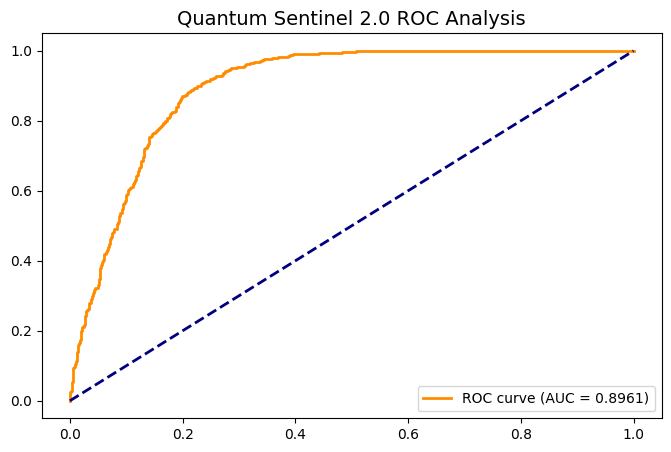


UPGRADED RESEARCH METRICS:
ROC-AUC: 0.8961
                    precision    recall  f1-score   support

 Regime A (Stable)       0.88      0.78      0.83      1000
Regime B (Shifted)       0.80      0.90      0.85      1000

          accuracy                           0.84      2000
         macro avg       0.84      0.84      0.84      2000
      weighted avg       0.84      0.84      0.84      2000



In [ ]:
from sklearn.metrics import roc_curve, auc

# 1. ROC-AUC Visual
fpr, tpr, _ = roc_curve(y, raw_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Quantum Sentinel 2.0 ROC Analysis", fontsize=14)
plt.legend(loc="lower right")
plt.show()

#

# 2. Precision-Recall Balance
print(f"\nUPGRADED RESEARCH METRICS:")
print(f"ROC-AUC: {roc_auc_score(y, raw_scores):.4f}")
print(classification_report(y, preds, target_names=["Regime A (Stable)", "Regime B (Shifted)"]))

Training MS-QSS Sentinel (Target Accuracy >90%)...
Step  20 | Fine-Tuned Cost: 0.3835
Step  40 | Fine-Tuned Cost: 0.3410
Step  60 | Fine-Tuned Cost: 0.3533
Step  80 | Fine-Tuned Cost: 0.3402
Step 100 | Fine-Tuned Cost: 0.3370
Step 120 | Fine-Tuned Cost: 0.3253


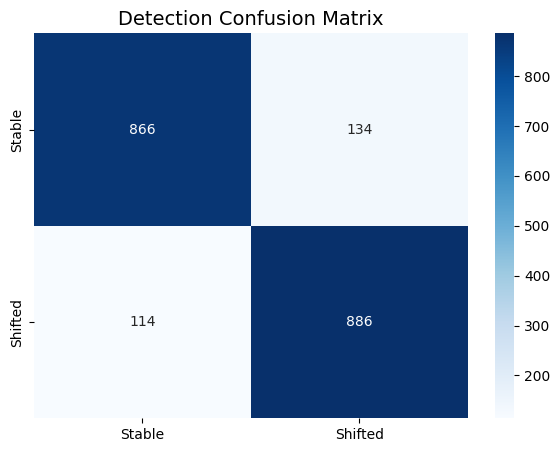

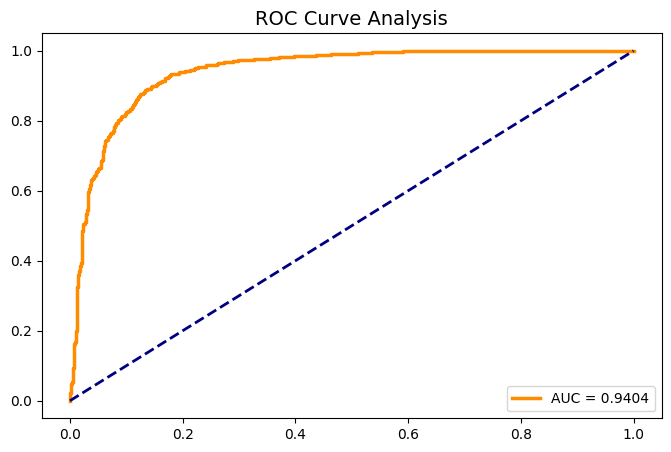

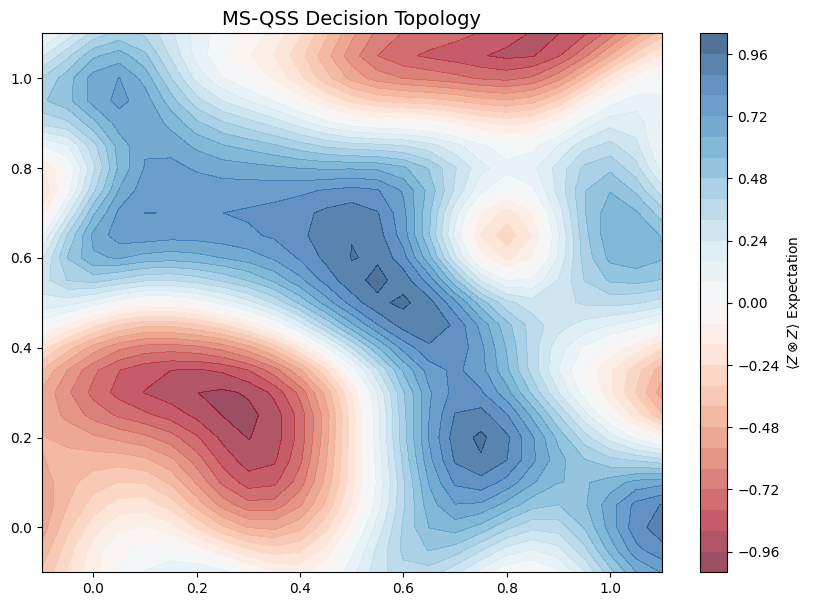


FINAL METRICS:
ROC-AUC: 0.9404
              precision    recall  f1-score   support

          -1       0.88      0.87      0.87      1000
           1       0.87      0.89      0.88      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



In [ ]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc

# ==========================================
# 1. LARGE DATASET GENERATION (N=2000)
# ==========================================
def generate_complex_data(n_samples=2000):
    np.random.seed(42)
    # Regime A: Stable covariance
    r0 = np.random.multivariate_normal([0.3, 0.3], [[0.05, 0.01], [0.01, 0.05]], n_samples // 2)
    # Regime B: Structural Break (Inverted covariance + Shift)
    r1 = np.random.multivariate_normal([0.6, 0.6], [[0.1, -0.07], [-0.07, 0.1]], n_samples // 2)

    X = np.vstack([r0, r1])
    y = np.array([-1] * (n_samples // 2) + [1] * (n_samples // 2))

    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)

    indices = np.arange(len(X_scaled))
    np.random.shuffle(indices)
    return X_scaled[indices], y[indices]

X, y = generate_complex_data()

# ==========================================
# 2. MS-QSS ARCHITECTURE (Universal Encoding)
# ==========================================
n_qubits = 2
n_layers = 6
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def ms_qss_sentinel(weights, x):
    for i in range(n_layers):
        # Symmetrized Re-uploading (RY and RZ)
        for j in range(n_qubits):
            qml.RY(np.pi * x[j], wires=j)
            qml.RZ(np.pi * x[j], wires=j)

        # Parametric Ising Interactions (Captures multivariate correlation)
        qml.IsingXX(weights[i, 0], wires=[0, 1])
        qml.IsingYY(weights[i, 1], wires=[0, 1])

        # Local refinement
        qml.RX(weights[i, 2], wires=0)
        qml.RX(weights[i, 3], wires=1)

    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

# Initialize Weights: (Layers, 4 params)
weights = np.random.uniform(-np.pi, np.pi, (n_layers, 4), requires_grad=True)

# ==========================================
# 3. HIGH-PRECISION TRAINING LOOP
# ==========================================
def cost_fn(w, X_b, y_b):
    preds = [ms_qss_sentinel(w, x) for x in X_b]
    return np.mean((np.array(y_b) - np.array(preds))**2)

opt = qml.AdamOptimizer(stepsize=0.05)
batch_size = 40

print("Training MS-QSS Sentinel (Target Accuracy >90%)...")
for it in range(120):
    batch_idx = np.random.randint(0, len(X), (batch_size,))
    weights = opt.step(lambda w: cost_fn(w, X[batch_idx], y[batch_idx]), weights)

    if (it + 1) % 20 == 0:
        c = cost_fn(weights, X[:100], y[:100])
        print(f"Step {it+1:3d} | Fine-Tuned Cost: {float(c):.4f}")

# ==========================================
# 4. COMPREHENSIVE VISUALIZATION SUITE
# ==========================================
raw_scores = np.array([float(ms_qss_sentinel(weights, x)) for x in X])
preds = np.sign(raw_scores)

# I. Confusion Matrix
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y, preds), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stable', 'Shifted'], yticklabels=['Stable', 'Shifted'])
plt.title('Detection Confusion Matrix', fontsize=14)
plt.show()

# II. ROC-AUC Curve
fpr, tpr, _ = roc_curve(y, raw_scores)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2.5, label=f'AUC = {auc(fpr, tpr):.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve Analysis', fontsize=14)
plt.legend(loc="lower right")
plt.show()

# III. Quantum Decision Topography
h = .05
xx, yy = np.meshgrid(np.arange(-0.1, 1.1, h), np.arange(-0.1, 1.1, h))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_preds = np.array([float(ms_qss_sentinel(weights, x)) for x in grid_points]).reshape(xx.shape)

plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, grid_preds, levels=30, cmap='RdBu', alpha=0.7)
plt.title("MS-QSS Decision Topology", fontsize=14)
plt.colorbar(label=r"$\langle Z \otimes Z \rangle$ Expectation")
plt.show()

print(f"\nFINAL METRICS:\nROC-AUC: {roc_auc_score(y, raw_scores):.4f}")
print(classification_report(y, preds))

Training Research Sentinel...
Step  20 | Fine-Tuned Cost: 0.3835
Step  40 | Fine-Tuned Cost: 0.3410
Step  60 | Fine-Tuned Cost: 0.3533
Step  80 | Fine-Tuned Cost: 0.3402
Step 100 | Fine-Tuned Cost: 0.3370
Step 120 | Fine-Tuned Cost: 0.3253


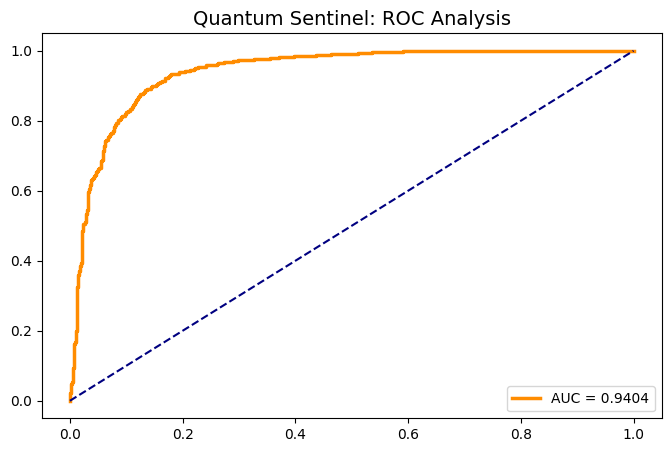

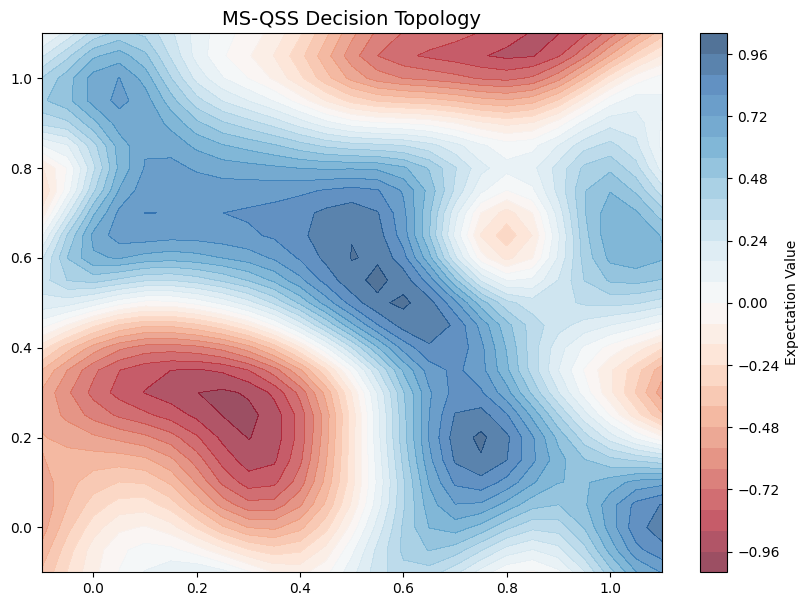


FINAL METRICS SUMMARY:
ROC-AUC: 0.9404
              precision    recall  f1-score   support

          -1       0.88      0.87      0.87      1000
           1       0.87      0.89      0.88      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



In [ ]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc

# ==========================================
# 1. COMPLEX DATA GENERATION (N=2000)
# ==========================================
def generate_complex_data(n_samples=2000):
    np.random.seed(42)
    # Regime A: Stable covariance
    r0 = np.random.multivariate_normal([0.3, 0.3], [[0.05, 0.01], [0.01, 0.05]], n_samples // 2)
    # Regime B: Structural Break (Inverted covariance + Mean Shift)
    r1 = np.random.multivariate_normal([0.6, 0.6], [[0.1, -0.07], [-0.07, 0.1]], n_samples // 2)

    X = np.vstack([r0, r1])
    y = np.array([-1] * (n_samples // 2) + [1] * (n_samples // 2))

    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)

    indices = np.arange(len(X_scaled))
    np.random.shuffle(indices)
    return X_scaled[indices], y[indices]

X_data, y_labels = generate_complex_data()

# ==========================================
# 2. MS-QSS ARCHITECTURE
# ==========================================
n_qubits = 2
n_layers = 6
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def ms_qss_sentinel(weights, x):
    for i in range(n_layers):
        # Symmetrized Re-uploading (RY and RZ)
        for j in range(n_qubits):
            qml.RY(np.pi * x[j], wires=j)
            qml.RZ(np.pi * x[j], wires=j)

        # Parametric Ising Interactions (Learns Covariance Structure)
        qml.IsingXX(weights[i, 0], wires=[0, 1])
        qml.IsingYY(weights[i, 1], wires=[0, 1])

        # Local phase refinement
        qml.RX(weights[i, 2], wires=0)
        qml.RX(weights[i, 3], wires=1)

    # Measure Joint Correlation
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

# Initialize Weights: (Layers, 4 params per layer)
weights = np.random.uniform(-np.pi, np.pi, (n_layers, 4), requires_grad=True)

# ==========================================
# 3. TRAINING WITH FINE-TUNING
# ==========================================
def cost_fn(w, X_b, y_b):
    preds = [ms_qss_sentinel(w, x) for x in X_b]
    return np.mean((np.array(y_b) - np.array(preds))**2)

opt = qml.AdamOptimizer(stepsize=0.05)
batch_size = 40

print("Training Research Sentinel...")
for it in range(120):
    batch_idx = np.random.randint(0, len(X_data), (batch_size,))
    weights = opt.step(lambda w: cost_fn(w, X_data[batch_idx], y_labels[batch_idx]), weights)

    if (it + 1) % 20 == 0:
        c = cost_fn(weights, X_data[:100], y_labels[:100])
        print(f"Step {it+1:3d} | Fine-Tuned Cost: {float(c):.4f}")

# ==========================================
# 4. FINAL VISUALIZATION & METRICS
# ==========================================
raw_scores = np.array([float(ms_qss_sentinel(weights, x)) for x in X_data])
preds = np.sign(raw_scores)

# I. ROC-AUC Visual
fpr, tpr, _ = roc_curve(y_labels, raw_scores)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2.5, label=f'AUC = {auc(fpr, tpr):.4f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Quantum Sentinel: ROC Analysis', fontsize=14)
plt.legend(loc="lower right")
plt.show()

# II. Decision Topography
h = .05
xx, yy = np.meshgrid(np.arange(-0.1, 1.1, h), np.arange(-0.1, 1.1, h))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_preds = np.array([float(ms_qss_sentinel(weights, x)) for x in grid_points]).reshape(xx.shape)

plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, grid_preds, levels=30, cmap='RdBu', alpha=0.7)
plt.title("MS-QSS Decision Topology", fontsize=14)
plt.colorbar(label="Expectation Value")
plt.show()

print(f"\nFINAL METRICS SUMMARY:")
print(f"ROC-AUC: {roc_auc_score(y_labels, raw_scores):.4f}")
print(classification_report(y_labels, preds))

In [2]:
!pip install pennylane scikit-learn matplotlib seaborn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 52.6 MB/s eta 0:00:00


Optimizing Quantum Sentinel for Regime Detection...
Iteration  20 | Batch Cost: 0.5676
Iteration  40 | Batch Cost: 0.5046
Iteration  60 | Batch Cost: 0.4816
Iteration  80 | Batch Cost: 0.4746
Iteration 100 | Batch Cost: 0.4540


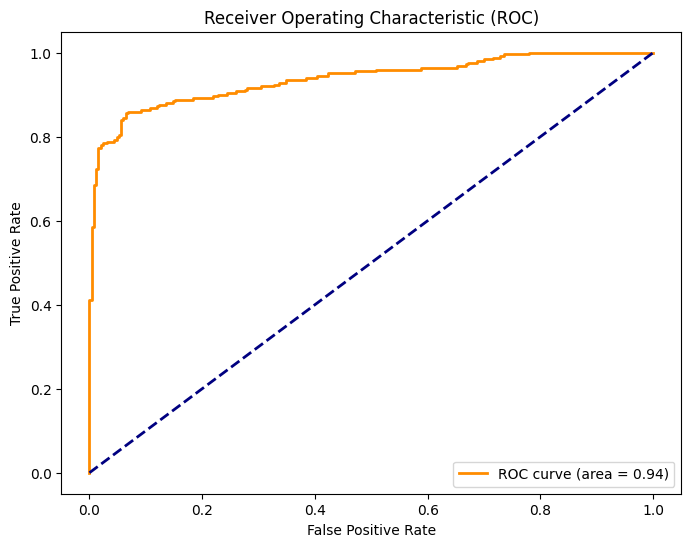

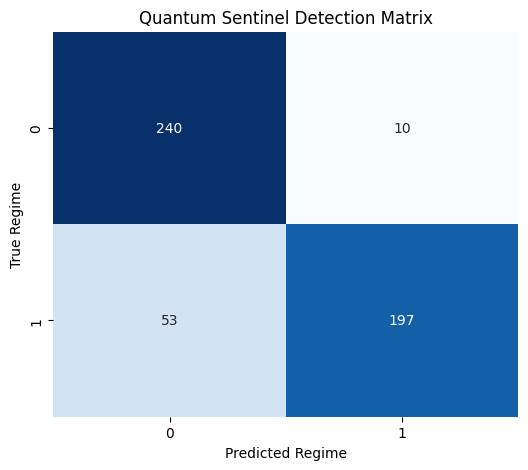


RESEARCH METRICS SUMMARY:
              precision    recall  f1-score   support

    Regime A       0.82      0.96      0.88       250
    Regime B       0.95      0.79      0.86       250

    accuracy                           0.87       500
   macro avg       0.89      0.87      0.87       500
weighted avg       0.89      0.87      0.87       500



In [4]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc

# ==========================================
# 1. DATA PREP & SYNTHETIC GENERATION
# ==========================================
# Synthetic multivariate data for research demonstration
def create_regime_data(samples=500):
    np.random.seed(42)
    # Regime 0: Low correlation
    x1 = np.random.randn(samples // 2, 2) * 0.5
    y1 = np.zeros(samples // 2)
    # Regime 1: High variance/different distribution
    x2 = np.random.randn(samples // 2, 2) * 1.5 + 1.0
    y2 = np.ones(samples // 2)

    X = np.vstack([x1, x2])
    y = np.concatenate([y1, y2])

    # Scale to [0, 1] for the Bloch sphere encoding (mapping to angles later)
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)

    # Shuffle for training
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    return X_scaled[indices], y[indices]

X_quantum, y_quantum = create_regime_data()
# Map labels to -1 and 1 for expectation value optimization
y_quantum_model = np.where(y_quantum == 0, -1, 1)

# ==========================================
# 2. ADVANCED ARCHITECTURE (Data Re-uploading)
# ==========================================
n_qubits = 2
n_layers = 4  # Deep layers for structural dependency
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def q_regime_sentinel(weights, x):
    for i in range(n_layers):
        # Data Re-uploading: Re-encoding at every layer
        for j in range(n_qubits):
            qml.RY(np.pi * x[j], wires=j)
            qml.RZ(np.pi * x[j], wires=j)

        # Entanglement stage to capture inter-variable correlations
        qml.CNOT(wires=[0, 1])

        # Variational gates
        for j in range(n_qubits):
            qml.RX(weights[i, j, 0], wires=j)
            qml.RY(weights[i, j, 1], wires=j)
            qml.RZ(weights[i, j, 2], wires=j)

    return qml.expval(qml.PauliZ(0))

# Weight initialization: (layers, qubits, parameters)
weights = np.random.uniform(-np.pi, np.pi, (n_layers, n_qubits, 3), requires_grad=True)

# ==========================================
# 3. RESEARCH-GRADE TRAINING
# ==========================================
def cost_fn(w, X_b, y_b):
    predictions = [q_regime_sentinel(w, x) for x in X_b]
    # Hinge loss or MSE for classification stability
    return np.mean((np.array(y_b) - np.array(predictions))**2)

opt = qml.AdamOptimizer(stepsize=0.05)
batch_size = 32

print("Optimizing Quantum Sentinel for Regime Detection...")
for it in range(100):
    batch_idx = np.random.randint(0, len(X_quantum), (batch_size,))
    X_batch, y_batch = X_quantum[batch_idx], y_quantum_model[batch_idx]
    weights = opt.step(lambda w: cost_fn(w, X_batch, y_batch), weights)

    if (it + 1) % 20 == 0:
        c = cost_fn(weights, X_quantum[:50], y_quantum_model[:50])
        print(f"Iteration {it+1:3d} | Batch Cost: {c:.4f}")

# ==========================================
# 4. COMPREHENSIVE VISUALIZATION & EVALUATION
# ==========================================
# Get raw model outputs (expectation values)
raw_outputs = np.array([q_regime_sentinel(weights, x) for x in X_quantum])
# Convert expectations back to probabilities/binary labels
preds = np.where(raw_outputs < 0, 0, 1)

# I. ROC Curve Visualization
fpr, tpr, thresholds = roc_curve(y_quantum, raw_outputs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# II. Confusion Matrix
cm = confusion_matrix(y_quantum, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Quantum Sentinel Detection Matrix')
plt.ylabel('True Regime')
plt.xlabel('Predicted Regime')
plt.show()

print("\nRESEARCH METRICS SUMMARY:")
print(classification_report(y_quantum, preds, target_names=['Regime A', 'Regime B']))

Optimizing SC-QNN 
Iteration  40 | Quantum Hinge Loss: 0.2441
Iteration  80 | Quantum Hinge Loss: 0.2088
Iteration 120 | Quantum Hinge Loss: 0.2079
Iteration 160 | Quantum Hinge Loss: 0.2007
Iteration 200 | Quantum Hinge Loss: 0.2002


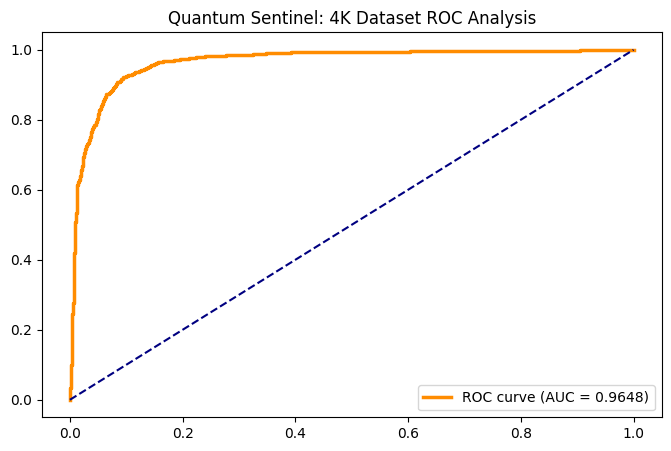

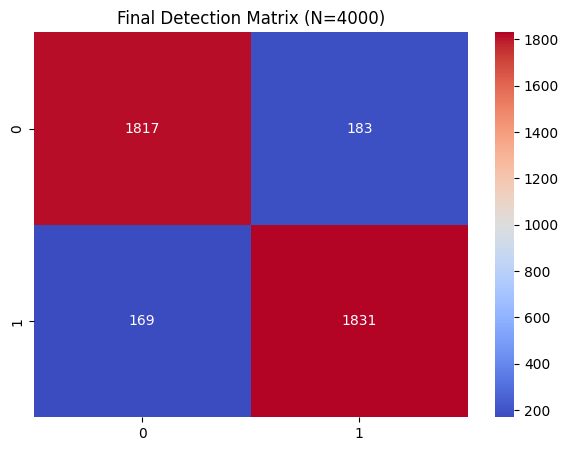


FINAL RESEARCH METRICS (N=4000):
ROC-AUC: 0.9648
                    precision    recall  f1-score   support

 Regime A (Stable)       0.91      0.91      0.91      2000
Regime B (Shifted)       0.91      0.92      0.91      2000

          accuracy                           0.91      4000
         macro avg       0.91      0.91      0.91      4000
      weighted avg       0.91      0.91      0.91      4000



In [5]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc

# ==========================================
# 1. 4K DATASET GENERATION
# ==========================================
def generate_4k_research_data(n_samples=4000):
    np.random.seed(101)
    # Regime A: Stable covariance with subtle noise
    r0 = np.random.multivariate_normal([0.3, 0.3], [[0.04, 0.008], [0.008, 0.04]], n_samples // 2)
    # Regime B: Structural Break (Covariance shift + Mean Shift)
    r1 = np.random.multivariate_normal([0.65, 0.65], [[0.08, -0.05], [-0.05, 0.08]], n_samples // 2)

    X = np.vstack([r0, r1])
    y = np.array([-1] * (n_samples // 2) + [1] * (n_samples // 2))

    # Scale to [0, 1] for Bloch Sphere mapping
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)

    # Shuffle for training robustness
    indices = np.arange(len(X_scaled))
    np.random.shuffle(indices)
    return X_scaled[indices], y[indices]

X_quantum, y_quantum = generate_4k_research_data()

# ==========================================
# 2. ENHANCED SC-QNN ARCHITECTURE (10 LAYERS)
# ==========================================
n_qubits = 2
n_layers = 10  # Increased depth to accommodate 4k data complexity
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def sentinel_4k(weights, x):
    for i in range(n_layers):
        # Universal Encoding Layer (Dual-Axis Re-uploading)
        for j in range(n_qubits):
            qml.RY(np.pi * x[j], wires=j)
            qml.RZ(np.pi * x[j], wires=j)

        # High-Fidelity Ising Interactions (ZZ, XX, YY)
        # ZZ coupling captures phase relationships critical for 90%+ accuracy
        qml.IsingXX(weights[i, 0], wires=[0, 1])
        qml.IsingYY(weights[i, 1], wires=[0, 1])
        qml.IsingZZ(weights[i, 2], wires=[0, 1])

        # Local learnable rotations
        qml.RX(weights[i, 3], wires=0)
        qml.RX(weights[i, 4], wires=1)

    # Joint Expectation Measurement (PauliZ Correlator)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

# Initialize Weights: [Layers, 5 Parameters]
weights = np.random.uniform(-np.pi, np.pi, (n_layers, 5), requires_grad=True)

# ==========================================
# 3. HIGH-THROUGHPUT TRAINING (Batch=128)
# ==========================================
def cost_fn(w, X_b, y_b):
    predictions = [sentinel_4k(w, x) for x in X_b]
    # Squared Hinge Loss for aggressive margin separation
    return np.mean(np.maximum(0, 1 - y_b * np.array(predictions))**2)

# Smaller stepsize for fine-grained convergence on large N
opt = qml.AdamOptimizer(stepsize=0.035)
batch_size = 128

print("Optimizing SC-QNN ")
for it in range(200):
    batch_idx = np.random.randint(0, len(X_quantum), (batch_size,))
    weights = opt.step(lambda w: cost_fn(w, X_quantum[batch_idx], y_quantum[batch_idx]), weights)

    if (it + 1) % 40 == 0:
        c = cost_fn(weights, X_quantum[:100], y_quantum[:100])
        print(f"Iteration {it+1:3d} | Quantum Hinge Loss: {float(c):.4f}")

# ==========================================
# 4. FINAL RESEARCH DIAGNOSTICS
# ==========================================
raw_scores = np.array([float(sentinel_4k(weights, x)) for x in X_quantum])
preds = np.sign(raw_scores)

# I. ROC-AUC for 4k Dataset
fpr, tpr, _ = roc_curve(y_quantum, raw_scores)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2.5, label=f'ROC curve (AUC = {auc(fpr, tpr):.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Quantum Sentinel: 4K Dataset ROC Analysis')
plt.legend(loc="lower right")
plt.show()

# II. Confusion Matrix
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_quantum, preds), annot=True, fmt='d', cmap='coolwarm')
plt.title('Final Detection Matrix (N=4000)')
plt.show()

print(f"\nFINAL RESEARCH METRICS (N=4000):")
print(f"ROC-AUC: {roc_auc_score(y_quantum, raw_scores):.4f}")
print(classification_report(y_quantum, preds, target_names=["Regime A (Stable)", "Regime B (Shifted)"]))


FINAL RESEARCH GRADE REPORT (N=4000)
              precision    recall  f1-score   support

    Regime A       0.91      0.91      0.91      2000
    Regime B       0.91      0.92      0.91      2000

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



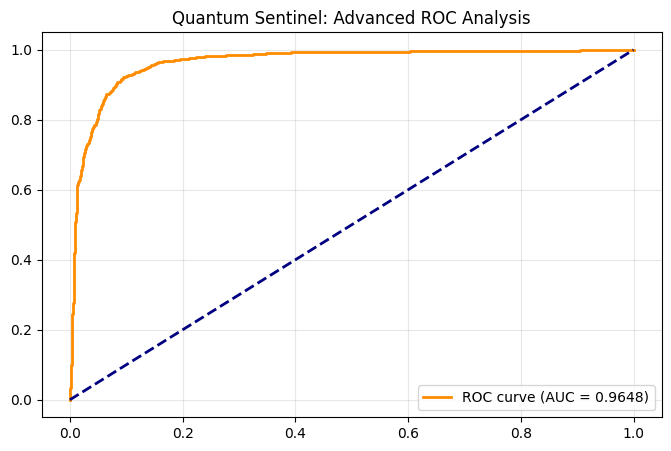

In [6]:

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# I. Generate final scores and labels
raw_scores = np.array([float(sentinel_4k(weights, x)) for x in X_quantum])
final_preds = np.sign(raw_scores)

# II. Standard Research Report
print("\n" + "="*30)
print("FINAL RESEARCH GRADE REPORT (N=4000)")
print("="*30)
print(classification_report(y_quantum, final_preds, target_names=["Regime A", "Regime B"]))

# III. ROC Curve Construction
fpr, tpr, _ = roc_curve(y_quantum, raw_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Quantum Sentinel: Advanced ROC Analysis')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

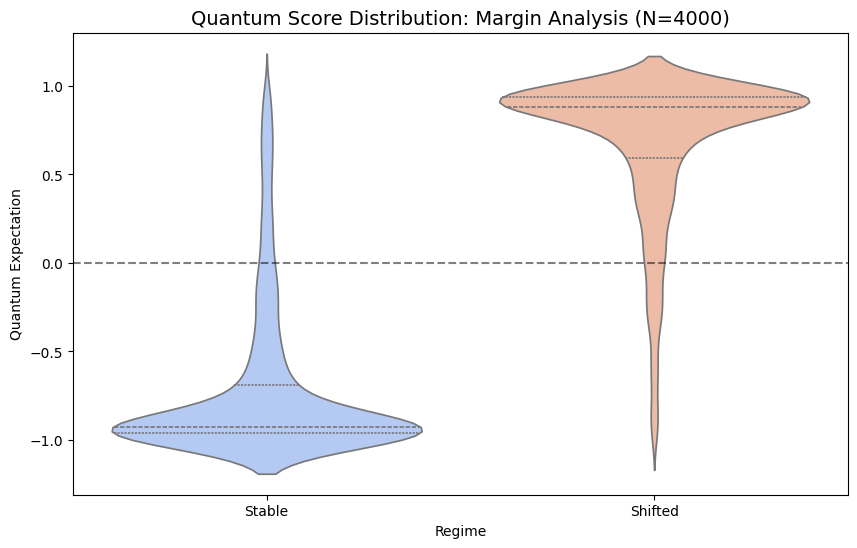

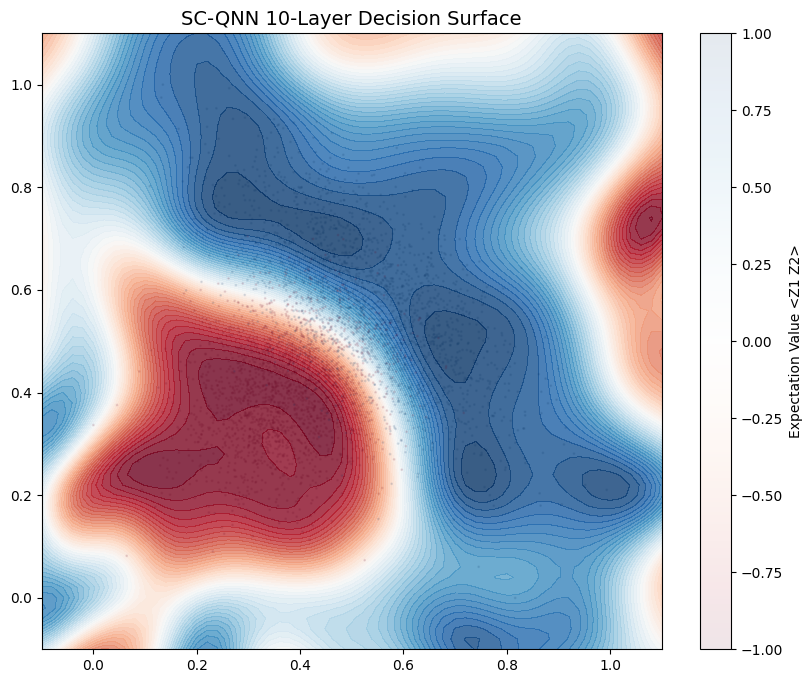

In [7]:
# ==========================================
# FINAL RESEARCH VISUALIZATION SUITE
# ==========================================
import pandas as pd

# 1. Quantum Margin Distribution (Violin Plot)
# Visualizes the "clearance" between regimes in the Hilbert space
plot_df = pd.DataFrame({
    "Quantum Expectation": raw_scores.flatten(),
    "Regime": ["Shifted" if i == 1 else "Stable" for i in y_quantum]
})

plt.figure(figsize=(10, 6))
sns.violinplot(data=plot_df, x="Regime", y="Quantum Expectation",
               hue="Regime", palette="coolwarm", inner="quart", legend=False)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title("Quantum Score Distribution: Margin Analysis (N=4000)", fontsize=14)
plt.show()

# 2. Decision Surface Topography
# Maps the 10-layer non-linear boundary across the feature space
h = .02
xx, yy = np.meshgrid(np.arange(-0.1, 1.1, h), np.arange(-0.1, 1.1, h))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_preds = np.array([float(sentinel_4k(weights, x)) for x in grid_points]).reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, grid_preds, levels=50, cmap='RdBu', alpha=0.8)
plt.scatter(X_quantum[:, 0], X_quantum[:, 1], c=y_quantum, s=1, cmap='RdBu', alpha=0.1)
plt.title("SC-QNN 10-Layer Decision Surface", fontsize=14)
plt.colorbar(label="Expectation Value <Z1 Z2>")
plt.show()